# Annotate Peaks

Annotate peak features such as GC content, gene features, distances from nearest genes, etc.

In [1]:
library(annotatr)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(patchwork)
library(GenomicRanges)


Attaching package: ‘patchwork’


The following object is masked from ‘package:annotatr’:

    plot_annotation


Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply

In [2]:
BED_DIR = "./beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/"

In [3]:
bed_names = sub(".bed", "", list.files(sprintf("./%s/", BED_DIR), pattern="gc*"))
bed_names

[1] "gc_0.1_0.32"    "gc_0.32_0.35"   "gc_0.35_0.37"   "gc_0.37_0.395" 
 [5] "gc_0.395_0.42"  "gc_0.42_0.445"  "gc_0.445_0.475" "gc_0.475_0.51" 
 [9] "gc_0.51_0.56"   "gc_0.56_0.845"

In [4]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [6]:
get_annotated_df <- function(annotations, bed_names, bed_dir, percentage=T) {
    annotated = list()

    for (i in bed_names) {
        peaks = read.table(sprintf("%s/%s.bed", bed_dir, i))
        colnames(peaks) = c("chr", "start", "end")
        peaks = makeGRangesFromDataFrame(peaks)

        dm_annotated = annotate_regions(
        regions = peaks,
        annotations = annotations,
        ignore.strand = TRUE,
        quiet = TRUE)

        dm_annsum = summarize_annotations(
        annotated_regions = dm_annotated,
        quiet = TRUE)

        annotated[[i]] = dm_annsum
        }
    
    # specific to type of annotation, this one for gene level annotation
    annotated_df = data.frame(annotated[[1]])
    annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
    rownames(annotated_df) = annotated_df$annot.type
    annotated_df$annot.type = NULL
    colnames(annotated_df) = bed_names[1]

    for (i in bed_names[2:length(bed_names)]) {
        cur_df = annotated[[i]]
        rownames(cur_df) = cur_df$annot.type
        annotated_df[, sprintf("%s", i)] = cur_df[rownames(annotated_df), "n"]
    }
    
    # replace NA with 0
    annotated_df[is.na(annotated_df)] = 0
    
    # get percentage
    if (percentage) {
        annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))
    }

    annotated_df
}

## Genes

In [5]:
annotations = build_annotations(genome = 'hg38', annotations = c('hg38_basicgenes', 
                                                                 'hg38_genes_intergenic',
                                                                 'hg38_genes_intronexonboundaries'))

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




'select()' returned 1:1 mapping between keys and columns

Building promoters...

Building 1to5kb upstream of TSS...

Building intergenic...

Building 5UTRs...

Building 3UTRs...

Building exons...

Building introns...

Building intron exon boundaries...

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 131 out-of-bound ranges located on sequences
  chr1_GL383518v1_alt, chr2_GL383522v1_alt, chr5_GL339449v2_alt,
  chr5_KI270795v1_alt, chr5_KI270898v1_alt, chr6_KI270797v1_alt,
  chr6_KI270798v1_alt, chr6_KI270801v1_alt, chr7_GL383534v2_alt,
  chr7_KI270803v1_alt, chr7_KI270806v1_alt, chr7_KI270809v1_alt,
  chr8_KI270821v1_alt,

In [366]:
annotated = list()

for (i in bed_names) {
    peaks = read.table(sprintf("%s/%s.bed", BED_DIR, i))
    colnames(peaks) = c("chr", "start", "end")
    peaks = makeGRangesFromDataFrame(peaks)
    
    dm_annotated = annotate_regions(
    regions = peaks,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = TRUE)
    
    dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
    
    annotated[[i]] = dm_annsum
    }

In [367]:
# specific to type of annotation, this one for gene level annotation
annotated_df = data.frame(annotated[[1]])
annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
rownames(annotated_df) = annotated_df$annot.type
annotated_df$annot.type = NULL
colnames(annotated_df) = bed_names[1]

for (i in bed_names[2:length(bed_names)]) {
    cur_df = annotated[[i]]
    rownames(cur_df) = cur_df$annot.type
    annotated_df[, sprintf("%s", i)] = cur_df[rownames(annotated_df), "n"]
}

colnames(annotated_df) = sub("_", "-", lapply(strsplit(sub("_", ":", colnames(annotated_df)), ":"), "[[", 2))

Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [368]:
# rename rows
rownames(annotated_df) = lapply(strsplit(rownames(annotated_df), "_"), "[[", 3)

# get percentage
annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))

annotated_df

,0.1-0.32,0.32-0.35,0.35-0.37,0.37-0.395,0.395-0.42,0.42-0.445,0.445-0.475,0.475-0.51,0.51-0.56,0.56-0.845
1to5kb,6.5088757,6.022885,5.8350723,6.0835328,5.5638273,5.9062326,6.0929648,5.5891720,5.7453172,5.6058134
3UTRs,2.4047944,1.901964,1.9166860,1.5363236,1.5594389,1.0825440,1.0285804,1.0191083,0.7791595,1.1641703
5UTRs,0.2048248,0.123705,0.2241286,0.1698448,0.1724003,0.1751174,0.2119975,0.2070064,0.3384228,0.7266795
exons,4.1723562,4.113190,4.1347863,4.0453949,3.8554972,3.2157924,3.6903266,3.5828025,3.5888557,6.4956251
intergenic,28.2203004,30.361837,32.5372904,34.2623331,36.9563514,39.0909815,39.5257538,40.9394904,41.6732252,39.8339018
intronexonboundaries,3.9902898,3.788465,3.5474148,3.8523894,3.6752606,2.9133169,3.3527010,3.1289809,3.5180230,5.0422661
introns,52.5792748,51.925158,49.6406214,47.9734424,46.2581302,45.4748070,43.7107412,43.1130573,41.5945223,36.6899006
promoters,1.9192839,1.762796,2.1640003,2.0767390,1.9590941,2.1412083,2.3869347,2.4203822,2.7624744,4.4416432


In [369]:
head(melt(annotated_df))

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,1to5kb,0.1-0.32,6.5088757
2,3UTRs,0.1-0.32,2.4047944
3,5UTRs,0.1-0.32,0.2048248
4,exons,0.1-0.32,4.1723562
5,intergenic,0.1-0.32,28.2203004
6,intronexonboundaries,0.1-0.32,3.9902898


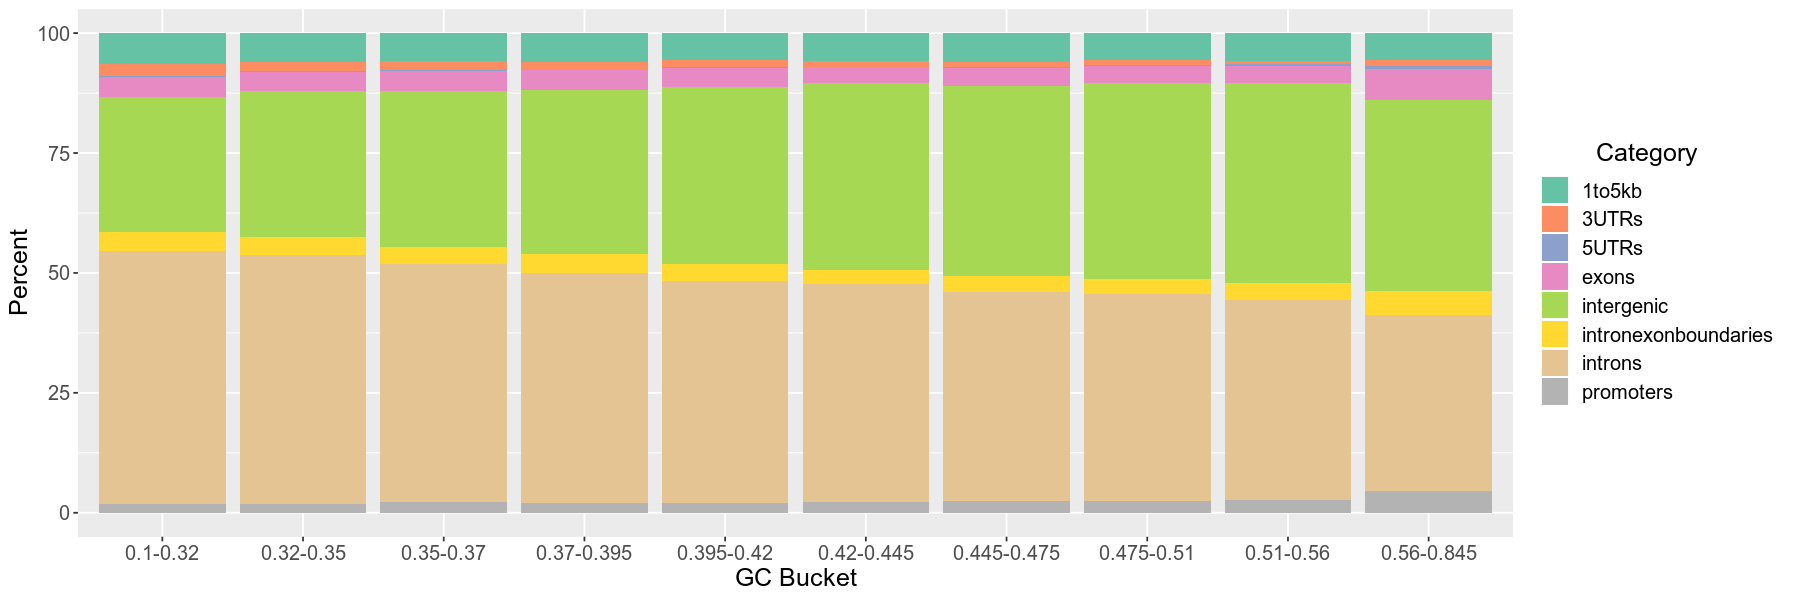

In [370]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data=melt(annotated_df), aes(x=factor(Var2, levels=colnames(annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_brewer(palette="Set2") +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## CpG

In [371]:
annotations = build_annotations(genome = 'hg38', annotations = c('hg38_cpgs'))

Building CpG islands...

Building CpG shores...

Building CpG shelves...

Building inter-CpG-islands...



In [372]:
annotated = list()

for (i in bed_names) {
    peaks = read.table(sprintf("%s/%s.bed", BED_DIR, i))
    colnames(peaks) = c("chr", "start", "end")
    peaks = makeGRangesFromDataFrame(peaks)
    
    dm_annotated = annotate_regions(
    regions = peaks,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = TRUE)
    
    dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
    
    annotated[[i]] = dm_annsum
    }

In [373]:
annotated[[1]]

annot.type,n
<chr>,<int>
hg38_cpg_inter,10812
hg38_cpg_shelves,62
hg38_cpg_shores,35


In [374]:
# specific to type of annotation, this one for CpG level annotation
annotated_df = data.frame(annotated[[1]])
annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
rownames(annotated_df) = annotated_df$annot.type
annotated_df$annot.type = NULL
colnames(annotated_df) = bed_names[1]

for (i in bed_names[2:length(bed_names)]) {
    cur_df = annotated[[i]]
    rownames(cur_df) = cur_df$annot.type
    annotated_df[, sprintf("%s", i)] = cur_df[rownames(annotated_df), "n"]
}

colnames(annotated_df) = sub("_", "-", lapply(strsplit(sub("_", ":", colnames(annotated_df)), ":"), "[[", 2))

Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [375]:
# rename rows
rownames(annotated_df) = lapply(strsplit(rownames(annotated_df), "_"), "[[", 3)

# get percentage
annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))

annotated_df

,0.1-0.32,0.32-0.35,0.35-0.37,0.37-0.395,0.395-0.42,0.42-0.445,0.445-0.475,0.475-0.51,0.51-0.56,0.56-0.845
inter,99.1108259,99.0198773,99.1572004,98.7449615,98.7902117,98.5436893,98.5796756,97.948718,96.702995,90.179939
shelves,0.5683381,0.6045617,0.5130084,0.7603518,0.7332050,0.8243268,0.6964171,0.952381,1.300485,1.885528
shores,0.3208360,0.3755611,0.3297911,0.4946867,0.4765833,0.6319839,0.7239073,1.098901,1.996520,7.934533


In [376]:
head(melt(annotated_df))

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,inter,0.1-0.32,99.1108259
2,shelves,0.1-0.32,0.5683381
3,shores,0.1-0.32,0.3208360
4,inter,0.32-0.35,99.0198773
5,shelves,0.32-0.35,0.6045617
6,shores,0.32-0.35,0.3755611


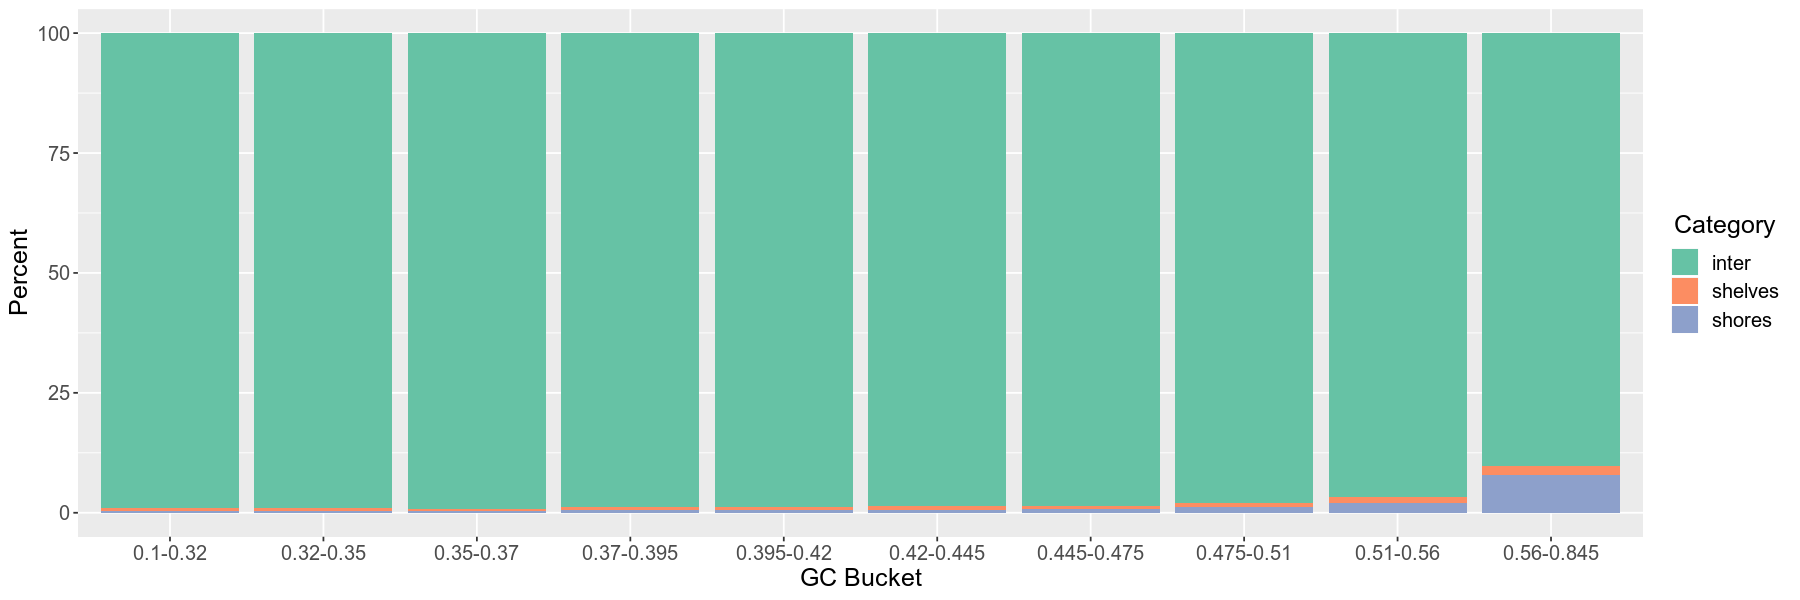

In [377]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data=melt(annotated_df), aes(x=factor(Var2, levels=colnames(annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_brewer(palette="Set2") +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## Distance From Nearest Gene

In [260]:
library(EnsDb.Hsapiens.v86)

In [261]:
edb <- EnsDb.Hsapiens.v86

In [262]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [263]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [264]:
plots = list()

for (i in bed_names) {
    # take mid of peaks
    peaks = read.table(sprintf("%s/%s.bed", BED_DIR, i))
    colnames(peaks) = c("chr", "start", "end")
    peaks$chr = sub("chr", "", peaks$chr)
    peaks_mid = as.integer((peaks$start+peaks$end)/2)
    peaks$start = peaks_mid
    peaks$end = peaks_mid+1
    peaks = makeGRangesFromDataFrame(peaks)
    
    dists = data.frame(distanceToNearest(peaks, tss.hg38, ignore.strand=TRUE))$distance
    print(median(dists))
    plots[[i]] <- ggplot(data.frame(d=dists+1), aes(x=d)) + 
        geom_histogram(bins=50, col='black', alpha=0.5, fill='red') +
        scale_x_log10() +
        coord_cartesian(xlim=c(1,1e7)) +
        ggtitle(sprintf("%s", i)) +  
        xlab("Distance from Nearest TSS") + ylab("Count") + 
        geom_vline(xintercept = 1000, linetype="dashed") +
        theme(plot.title = element_text(hjust = 0.5))
}

[1] 97918.5
[1] 104055
[1] 106115.5
[1] 107147.5
[1] 108597.5
[1] 102589.5
[1] 98485.5
[1] 95591.5
[1] 94023
[1] 97091


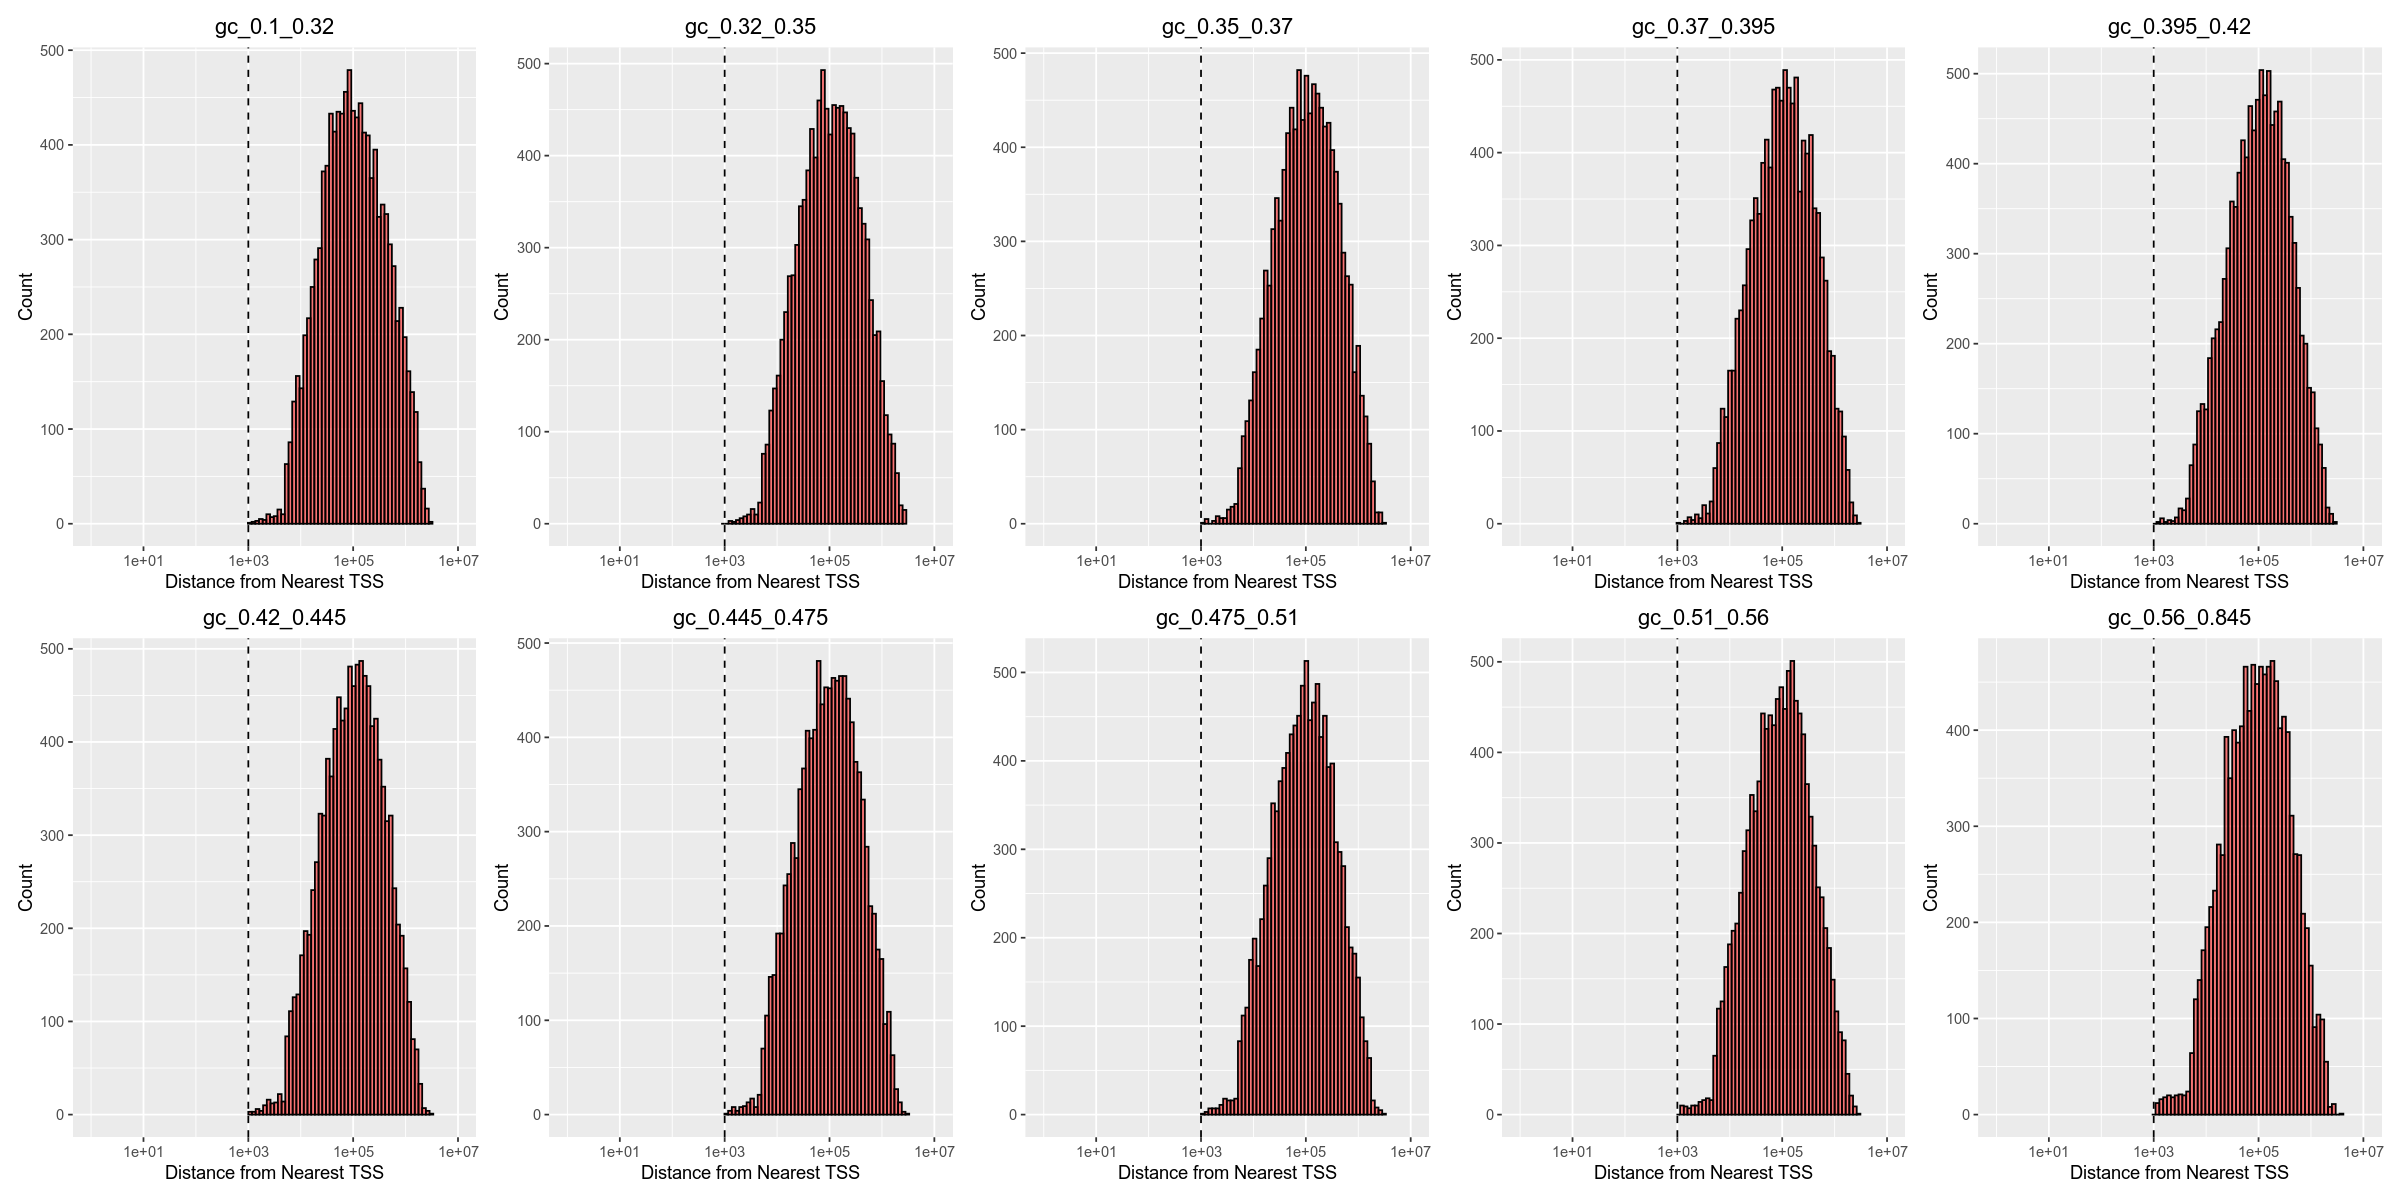

In [265]:
options(repr.plot.width = 20, repr.plot.height = 10)
wrap_plots(plots, ncol = 5)

## ChromHMM - Fibroblast

In [351]:
gzf = gzfile("/users/surag/kundajelab/scATAC-reprog/resources/ChromHMM/E055_15_coreMarks_hg38lift_mnemonics.bed.gz")
gr = read.table(gzf)
colnames(gr) = c("chr", "start", "end", "type")
annotations = makeGRangesFromDataFrame(gr)
annotations$type = gr$type
annotations

GRanges object with 671383 ranges and 1 metadata column:
           seqnames            ranges strand |        type
              <Rle>         <IRanges>  <Rle> |    <factor>
       [1]     chr1       10000-10800      * |       9_Het
       [2]     chr1       10800-12600      * |    15_Quies
       [3]     chr1       12600-18400      * |      5_TxWk
       [4]     chr1       18400-88600      * |    15_Quies
       [5]     chr1       88600-90600      * | 14_ReprPCWk
       ...      ...               ...    ... .         ...
  [671379]     chrY 56887453-57217249      * |    15_Quies
  [671380]     chrM           0-12799      * |    15_Quies
  [671381]     chrM       12799-12999      * |       9_Het
  [671382]     chrM       12999-13199      * |  8_ZNF/Rpts
  [671383]     chrM       13199-16398      * |      5_TxWk
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [352]:
annotated = list()

for (i in bed_names) {
    peaks = read.table(sprintf("%s/%s.bed", BED_DIR, i))
    colnames(peaks) = c("chr", "start", "end")
    peaks = makeGRangesFromDataFrame(peaks)
    
    dm_annotated = annotate_regions(
    regions = peaks,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = TRUE)
    
    dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
    
    annotated[[i]] = dm_annsum
    }

In [353]:
# specific to type of annotation, this one for CpG level annotation
annotated_df = data.frame(annotated[[1]])
annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
rownames(annotated_df) = annotated_df$annot.type
annotated_df$annot.type = NULL
colnames(annotated_df) = bed_names[1]

for (i in bed_names[2:length(bed_names)]) {
    cur_df = annotated[[i]]
    rownames(cur_df) = cur_df$annot.type
    annotated_df[, sprintf("%s", i)] = cur_df[rownames(annotated_df), "n"]
}

colnames(annotated_df) = sub("_", "-", lapply(strsplit(sub("_", ":", colnames(annotated_df)), ":"), "[[", 2))

Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [354]:
# replace NA with 0
annotated_df[is.na(annotated_df)] = 0

In [355]:
# rename rows
rownames(annotated_df) = lapply(strsplit(rownames(annotated_df), "_"), "[[", 2)

# get percentage
annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))

annotated_df

,0.1-0.32,0.32-0.35,0.35-0.37,0.37-0.395,0.395-0.42,0.42-0.445,0.445-0.475,0.475-0.51,0.51-0.56,0.56-0.845
TssA,0.09941256,0.0631484,0.01797107,0.06272401,0.01788269,0.06247769,0.04459508,0.08892841,0.1427807,0.1363760
ReprPC,0.19882512,0.4330176,0.63797286,1.13799283,1.57367668,2.05283827,3.24652158,4.01956425,6.1217205,8.1643786
ReprPCWk,6.39855400,7.9296346,9.25509929,10.57347670,12.19599428,13.55765798,14.65394220,15.93597154,15.7683384,12.2374761
Quies,62.18707637,62.4176816,62.64713811,60.46594982,58.56580830,55.64084256,50.45486978,45.19341930,37.7744066,32.7847986
Tx,3.27157704,3.8610735,4.19624405,4.43548387,3.99678112,3.83791503,4.21869426,4.52645620,4.5154382,4.2276571
TxWk,25.04292815,21.3441588,17.69251505,16.13799283,13.55507868,12.32595502,11.89796646,10.25344598,8.3794396,7.0188199
EnhG,0.11748757,0.1714028,0.23362387,0.31362007,0.25035765,0.24098536,0.37459864,0.45353490,0.4372658,0.4818620
Enh,1.18391324,1.5155616,1.90493306,1.90860215,2.42310443,2.14209211,2.08704959,1.99199644,1.6776727,0.8728066
Het,1.50022594,2.2643212,3.41450265,4.96415771,7.42131617,10.13923599,13.02176240,17.53668297,25.1829377,34.0758251


In [356]:
head(melt(annotated_df))

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,TssA,0.1-0.32,0.09941256
2,ReprPC,0.1-0.32,0.19882512
3,ReprPCWk,0.1-0.32,6.39855400
4,Quies,0.1-0.32,62.18707637
5,Tx,0.1-0.32,3.27157704
6,TxWk,0.1-0.32,25.04292815


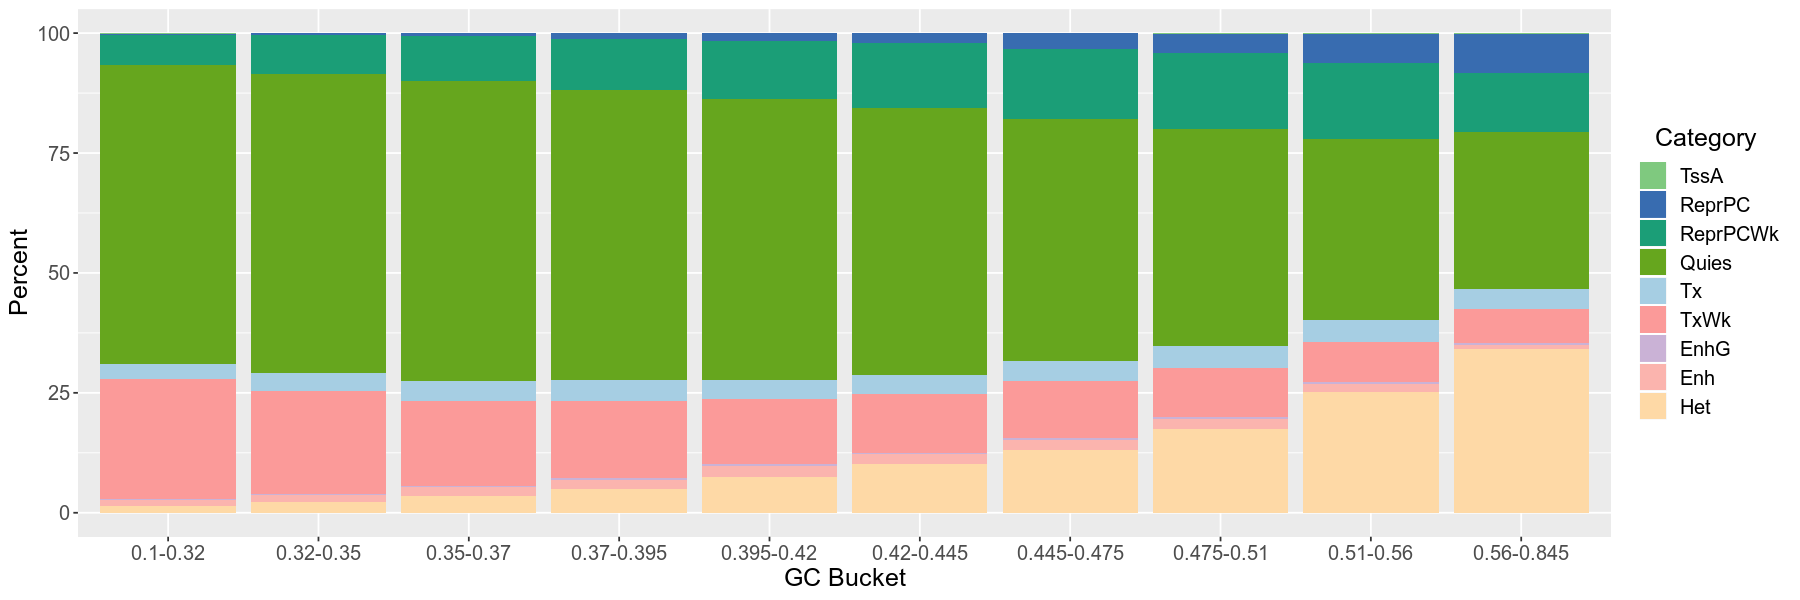

In [357]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data=melt(annotated_df), aes(x=factor(Var2, levels=colnames(annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_manual(values=col_vector[seq(1,length(col_vector),4)]) +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## ChromHMM - ESC

In [358]:
gzf = gzfile("/users/surag/kundajelab/scATAC-reprog/resources/ChromHMM/E003_15_coreMarks_hg38lift_mnemonics.bed.gz")
gr = read.table(gzf)
colnames(gr) = c("chr", "start", "end", "type")
annotations = makeGRangesFromDataFrame(gr)
annotations$type = gr$type

In [359]:
annotated = list()

for (i in bed_names) {
    peaks = read.table(sprintf("%s/%s.bed", BED_DIR, i))
    colnames(peaks) = c("chr", "start", "end")
    peaks = makeGRangesFromDataFrame(peaks)
    
    dm_annotated = annotate_regions(
    regions = peaks,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = TRUE)
    
    dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
    
    annotated[[i]] = dm_annsum
    }

In [360]:
annotated[[1]]

annot.type,n
<fct>,<int>
1_TssA,9
12_EnhBiv,2
13_ReprPC,24
14_ReprPCWk,136
15_Quies,7929
2_TssAFlnk,4
4_Tx,473
5_TxWk,2072
6_EnhG,5


In [361]:
# specific to type of annotation, this one for CpG level annotation
annotated_df = data.frame(annotated[[1]])
annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
rownames(annotated_df) = annotated_df$annot.type
annotated_df$annot.type = NULL
colnames(annotated_df) = bed_names[1]

for (i in bed_names[2:length(bed_names)]) {
    cur_df = annotated[[i]]
    rownames(cur_df) = cur_df$annot.type
    annotated_df[, sprintf("%s", i)] = cur_df[rownames(annotated_df), "n"]
}

colnames(annotated_df) = sub("_", "-", lapply(strsplit(sub("_", ":", colnames(annotated_df)), ":"), "[[", 2))

Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [362]:
# rename rows
rownames(annotated_df) = lapply(strsplit(rownames(annotated_df), "_"), "[[", 2)

# get percentage
annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))

annotated_df

,0.1-0.32,0.32-0.35,0.35-0.37,0.37-0.395,0.395-0.42,0.42-0.445,0.445-0.475,0.475-0.51,0.51-0.56,0.56-0.845
TssA,0.08108839,0.20546721,0.3530762,0.3396621,0.4321895,0.8326895,1.3660036,1.9212706,1.3253527,3.8331747
EnhBiv,0.01801964,0.13400036,0.1765381,0.3832085,0.5877777,0.7039231,0.6573892,0.7514303,0.9149209,0.8652765
ReprPC,0.21623570,0.32160086,0.3265955,0.5138478,0.7779410,0.6266632,0.7513020,0.5721117,0.6156477,0.8652765
ReprPCWk,1.22533562,1.17920314,1.5005737,1.6460547,1.6682514,2.0173405,1.9636302,2.3311417,2.6421548,2.5266073
Quies,71.43886837,71.31499017,69.3618148,64.8841665,62.8317054,60.1253326,57.9612396,55.8620101,54.4164173,51.1724496
TssAFlnk,0.03603928,0.04466679,0.1059229,0.2351507,0.3630392,0.5579878,0.6488517,0.8795150,0.8379649,1.1162066
Tx,4.26164519,4.16294443,3.9632801,3.8059572,3.1376956,2.6182505,2.7917698,2.7580907,2.6678068,2.8554123
TxWk,18.66834850,16.19617652,14.8733339,14.8754572,12.8187397,12.4474204,12.1745070,12.1082743,10.7652843,7.8826685
EnhG,0.04504910,0.03573343,0.1059229,0.1045114,0.2420261,0.2918705,0.3756510,0.3757151,0.3334758,0.3461106
Enh,3.00027029,4.99374665,7.2821961,10.7559659,14.2795402,15.8039317,16.3578929,16.5143882,17.3236426,12.3561478


In [363]:
head(melt(annotated_df))

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,TssA,0.1-0.32,0.08108839
2,EnhBiv,0.1-0.32,0.01801964
3,ReprPC,0.1-0.32,0.21623570
4,ReprPCWk,0.1-0.32,1.22533562
5,Quies,0.1-0.32,71.43886837
6,TssAFlnk,0.1-0.32,0.03603928


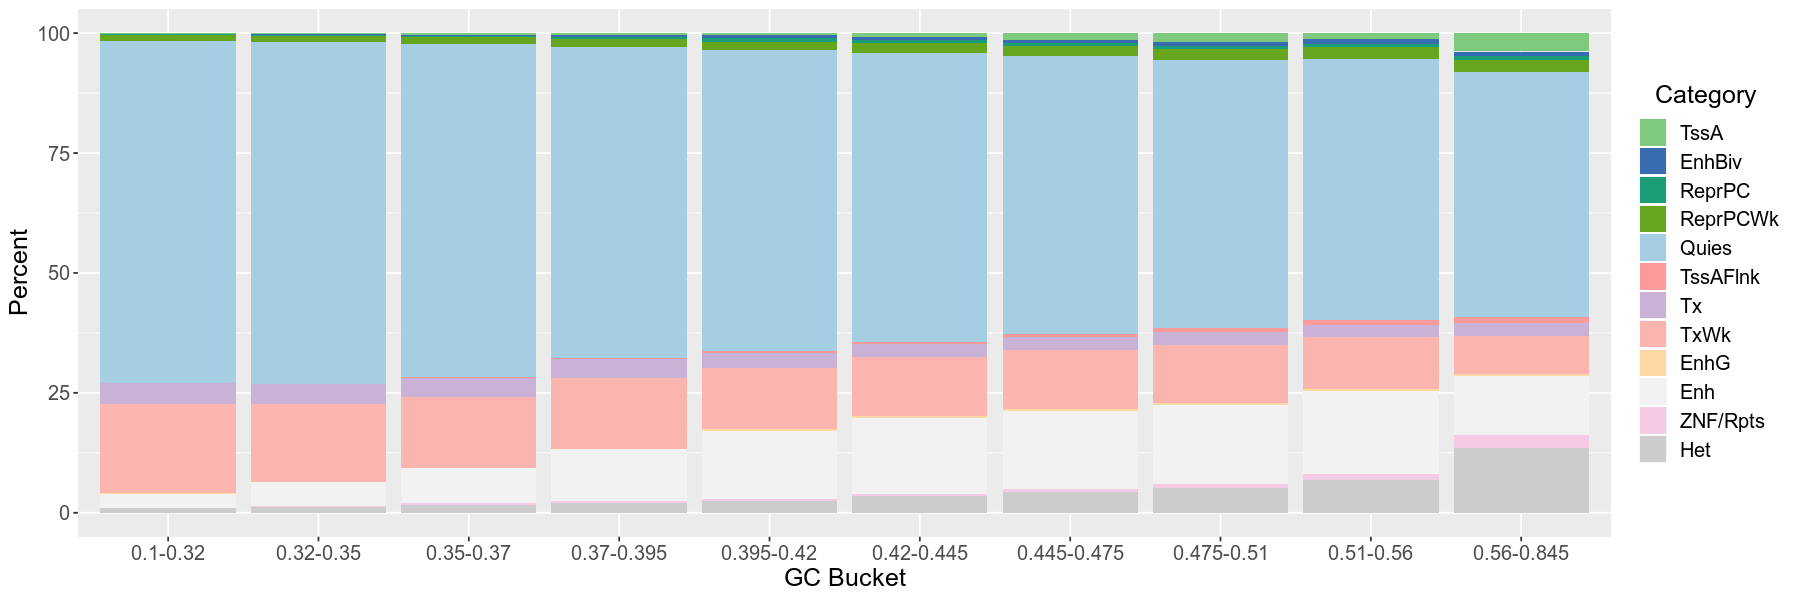

In [364]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data=melt(annotated_df), aes(x=factor(Var2, levels=colnames(annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_manual(values=col_vector[seq(1,length(col_vector),4)]) +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## DHS Index

In [8]:
gzf = gzfile("/users/surag/kundajelab/scATAC-reprog/resources/DHSIndex/DHS_Index_and_Vocabulary_hg38_WM20190703.txt.gz")
gr = read.table(gzf, sep='\t', header=T)
annotations = makeGRangesFromDataFrame(gr[,c("seqname", "start", "end")])
annotations$type = gr$component

In [9]:
dhs_annotated_df = get_annotated_df(annotations, bed_names, BED_DIR, percentage = F)

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”


In [10]:
dhs_annotated_df

,gc_0.1_0.32,gc_0.32_0.35,gc_0.35_0.37,gc_0.37_0.395,gc_0.395_0.42,gc_0.42_0.445,gc_0.445_0.475,gc_0.475_0.51,gc_0.51_0.56,gc_0.56_0.845
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Cancer / epithelial,340,421,498,534,600,672,676,600,528,334
Cardiac,77,117,155,216,228,219,212,196,159,119
Digestive,113,185,215,306,354,394,415,450,456,388
Lymphoid,301,328,372,421,396,419,396,396,510,499
Musculoskeletal,214,330,388,400,407,327,375,288,346,346
Myeloid / erythroid,168,261,271,324,351,391,399,374,418,376
Neural,929,1263,1446,1424,1437,1188,1001,817,666,611
Organ devel. / renal,68,98,170,242,306,350,380,375,429,585
Placental / trophoblast,159,258,338,401,493,591,649,795,861,812


In [11]:
dhs_annotated_df_percentage = 100*t(t(dhs_annotated_df)/colSums(dhs_annotated_df))

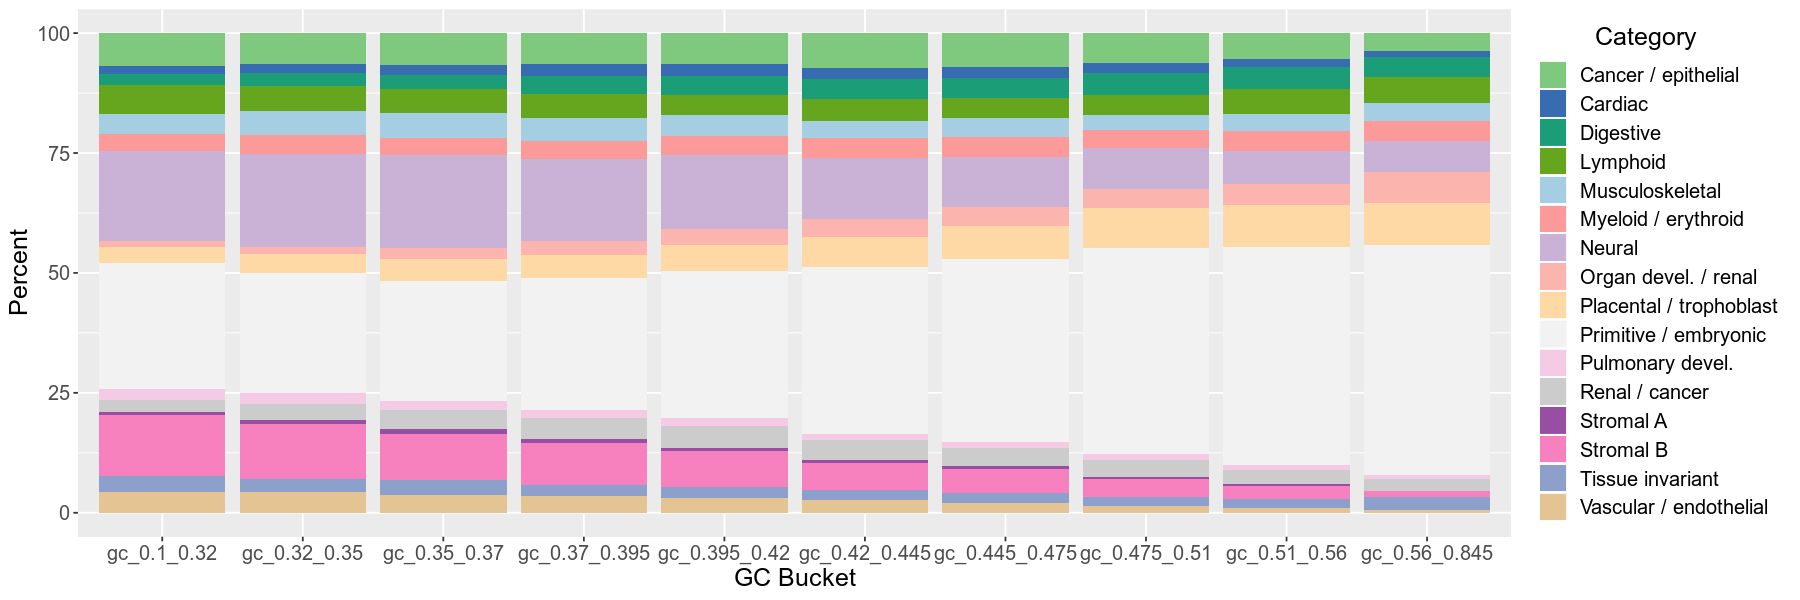

In [12]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data=melt(dhs_annotated_df_percentage), aes(x=factor(Var2, levels=colnames(dhs_annotated_df_percentage)),
                                    y=value, fill=Var1)) +
scale_fill_manual(values=col_vector[seq(1,length(col_vector),4)]) +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

In [15]:
dhs_annotated_expected = outer((rowSums(dhs_annotated_df)/sum(dhs_annotated_df)), colSums(dhs_annotated_df))
dhs_annotated_fc = dhs_annotated_df/dhs_annotated_expected
dhs_annotated_fc

,gc_0.1_0.32,gc_0.32_0.35,gc_0.35_0.37,gc_0.37_0.395,gc_0.395_0.42,gc_0.42_0.445,gc_0.445_0.475,gc_0.475_0.51,gc_0.51_0.56,gc_0.56_0.845
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cancer / epithelial,1.1098142,1.0442231,1.0768788,1.0314884,1.0502786,1.1631956,1.1411233,1.0106123,0.8681447,0.5859256
Cardiac,0.7701551,0.8892281,1.0270352,1.2784772,1.2229374,1.1615656,1.0965739,1.0115924,0.8010718,0.6396746
Digestive,0.5858140,0.7287740,0.7383901,0.9387597,0.9841617,1.0831526,1.1126125,1.2038040,1.1907840,1.0810299
Lymphoid,1.2659757,1.0482685,1.0364967,1.0478345,0.8931737,0.9345123,0.8613280,0.8594409,1.0804779,1.1279351
Musculoskeletal,1.0623946,1.2448754,1.2760566,1.1751244,1.0835486,0.8608589,0.9627597,0.7377795,0.8652369,0.9231513
Myeloid / erythroid,0.8560500,1.0105789,0.9147982,0.9769821,0.9591331,1.0565225,1.0514226,0.9833847,1.0728846,1.0296803
Neural,1.4633276,1.5117119,1.5088993,1.3273565,1.2138486,0.9923261,0.8154071,0.6640639,0.5284293,0.5172396
Organ devel. / renal,0.3845730,0.4211490,0.6369200,0.8099104,0.9280538,1.0496633,1.1113938,1.0943673,1.2221204,1.7780763
Placental / trophoblast,0.5040814,0.6215314,0.7098823,0.7523149,0.8381705,0.9935807,1.0640518,1.3005668,1.3749710,1.3835162


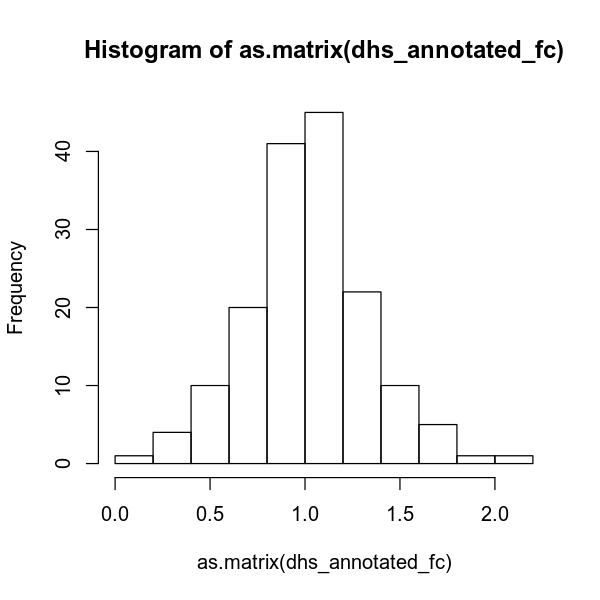

In [23]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.matrix(dhs_annotated_fc))

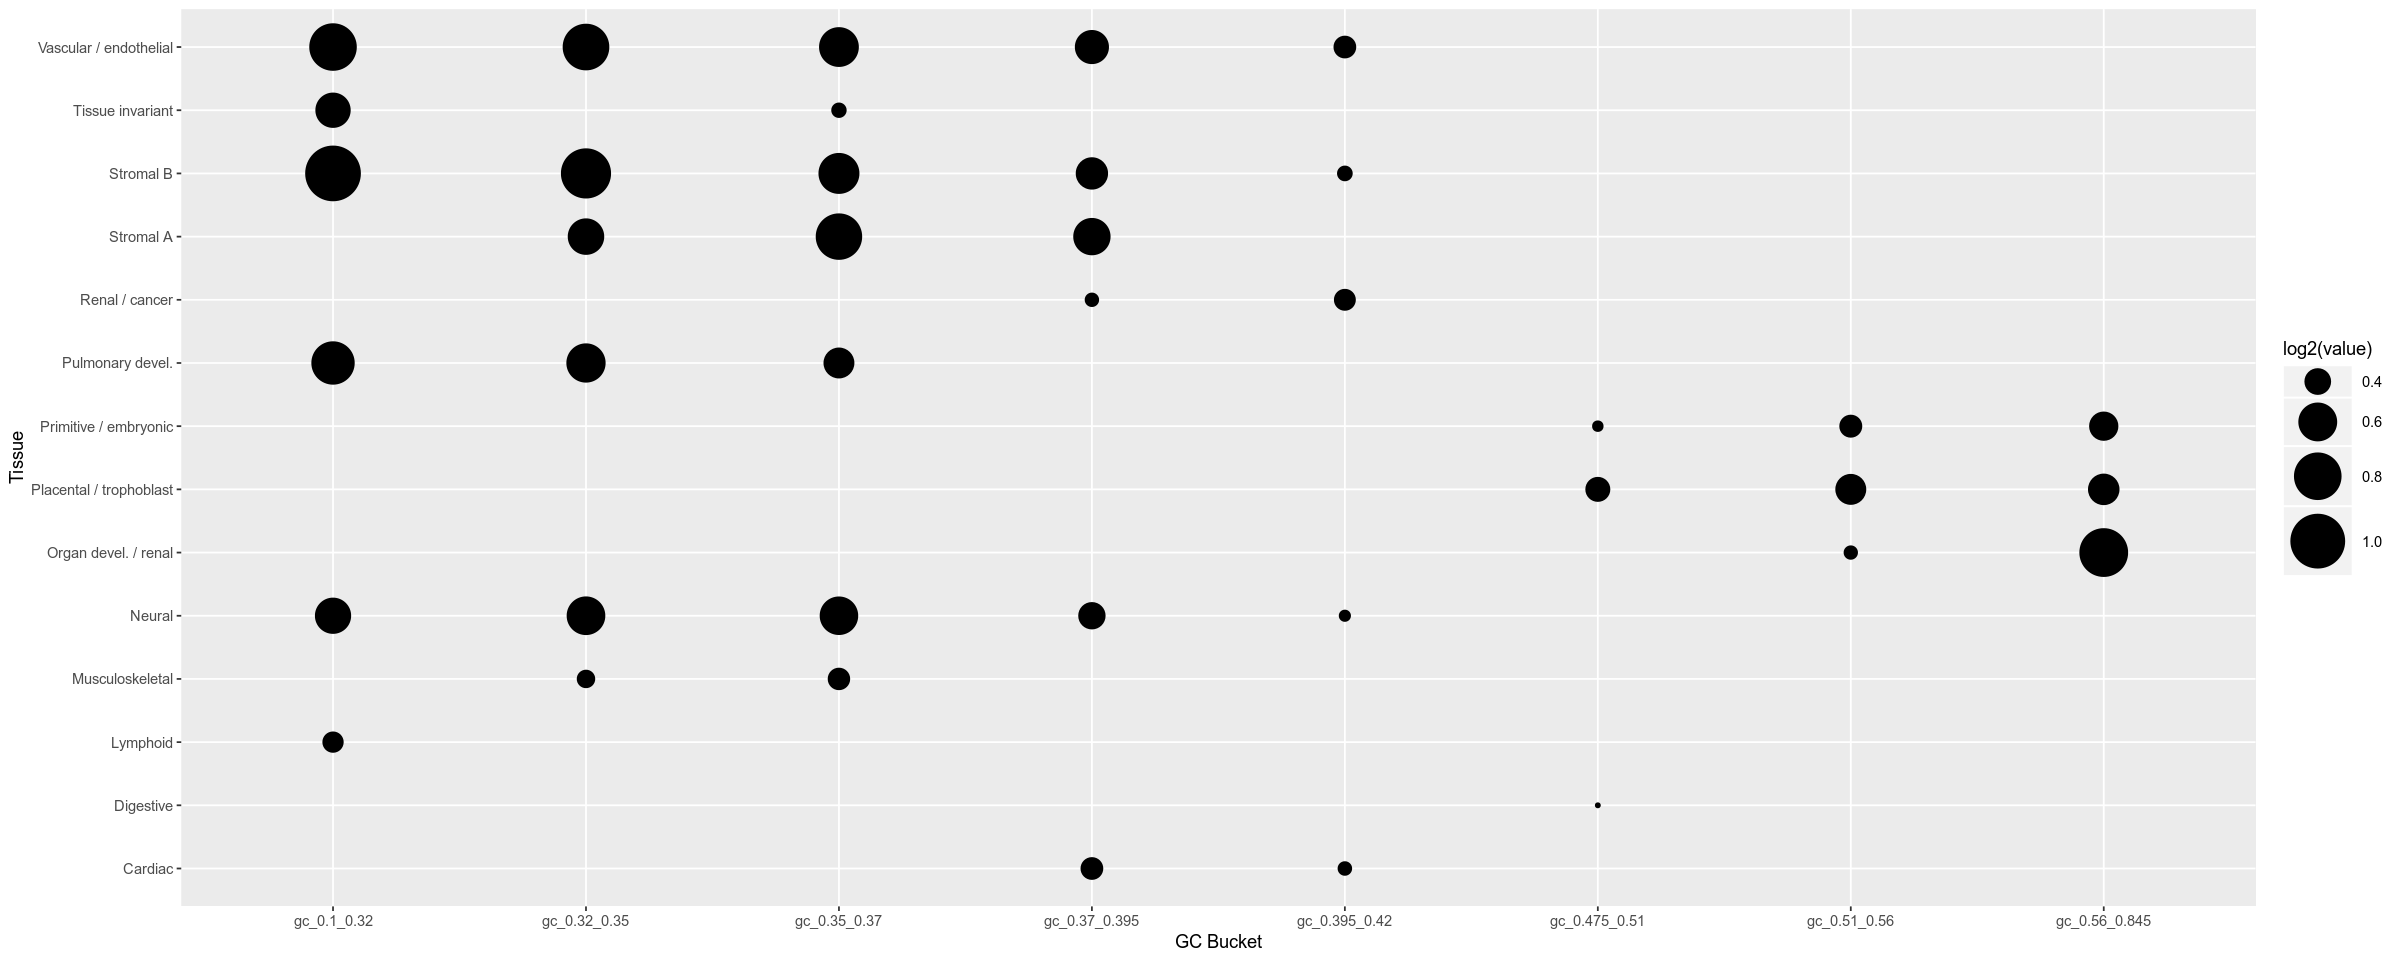

In [28]:
options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(melt(as.matrix(dhs_annotated_fc))[melt(as.matrix(dhs_annotated_fc))$value>1.2,], aes(x=factor(Var2, levels=colnames(dhs_annotated_fc)), 
                                                       y=Var1, size=log2(value))) +
xlab("GC Bucket") +
ylab("Tissue") +
geom_point() + 
scale_size_continuous(range = c(1, 15))